<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EDA-of-Dataset" data-toc-modified-id="EDA-of-Dataset-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EDA of Dataset</a></span></li><li><span><a href="#Interesting-Findings" data-toc-modified-id="Interesting-Findings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Interesting Findings</a></span><ul class="toc-item"><li><span><a href="#Changing-of-user-agents-in-a-single-connection." data-toc-modified-id="Changing-of-user-agents-in-a-single-connection.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Changing of user agents in a single connection.</a></span></li><li><span><a href="#Interesting-HTTP-Methods" data-toc-modified-id="Interesting-HTTP-Methods-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Interesting HTTP Methods</a></span></li><li><span><a href="#Interesting-SQL-like-commands-in-the-uri-field-(SQL-injection?)" data-toc-modified-id="Interesting-SQL-like-commands-in-the-uri-field-(SQL-injection?)-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Interesting SQL-like commands in the uri field (SQL injection?)</a></span></li></ul></li><li><span><a href="#Approach-Adopted" data-toc-modified-id="Approach-Adopted-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Approach Adopted</a></span></li><li><span><a href="#Creating-the-Rules" data-toc-modified-id="Creating-the-Rules-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creating the Rules</a></span></li><li><span><a href="#Scoring" data-toc-modified-id="Scoring-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Scoring</a></span></li></ul></div>

In [25]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import seaborn as sns
from src.helper import get_data, describe_df, get_raw_data
from sklearn.preprocessing import MinMaxScaler
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
display(HTML("<style>.container { width:100% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EDA of Dataset

From the given link, secrepo.com, we learn more about the background of the dataset, MACCDC2012:
U.S. National CyberWatch Mid-Atlantic Collegiate Cyber Defense Competition (MACCDC) is a unique experience for college and university students to test their cybersecurity knowledge and skills in a competitive environment. It focuses on the operational aspects of managing and protecting an existing network infrastructure. The teams are physically co-located in the same building. Each team is given physically identical computer configurations at the start of the competition. Throughout the competition, the teams have to ensure the systems supply the specified services while under attack from a volunteer Red Team. In addition, the teams have to satisfy periodic “injects” that simulate business activities IT staff must deal with in the real world. 
I also found a pdf from http://gauss.ececs.uc.edu/Courses/c6055/pdf/bro_log_vars.pdf that gives a little more explanation about the fields in dataset.

Thus, this dataset would have a mix of routine and suspicious traffic.   
We also see that this dataset is generated from the PCAP logs in the competition, and that there were potential supplementary information in other datasets like weird.log that might be able to help in our attempt to shortlist suspicious IPs.   
However, I will only focus on the information inside http.log in this question. This is because I am also not familiar with what the other logs were trying to log. 

In [6]:
#load raw data and explore the modal values for each column, missing values 
df = get_raw_data()
describe_df(df)

D:\Anaconda\envs\techtest\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,modal value,percentage_mode,nunique,nan_count,mem_usage,dtype,min,max
ts,2012-03-16 18:05:41.549999952,0.00,668595,0,16.387664,datetime64[ns],N/A,N/A
uid,CyVUbc3cLeE3WlNtRa,0.06,479204,0,16.387664,object,N/A,N/A
origin_h,192.168.203.63,62.95,71,0,16.387664,object,N/A,N/A
origin_p,33292,0.06,37686,0,8.193896,int32,1025,65535
response_h,192.168.229.101,63.96,88,0,16.387664,object,N/A,N/A
response_p,80,96.63,8,0,8.193896,int32,80,8834
depth,1,23.38,1207,0,8.193896,int32,0,1206
method,HEAD,63.28,144,0,16.387664,object,N/A,N/A
host,192.168.229.101,63.75,316,0,16.387664,object,N/A,N/A
uri,/main.php,5.70,1591740,0,16.387664,object,N/A,N/A


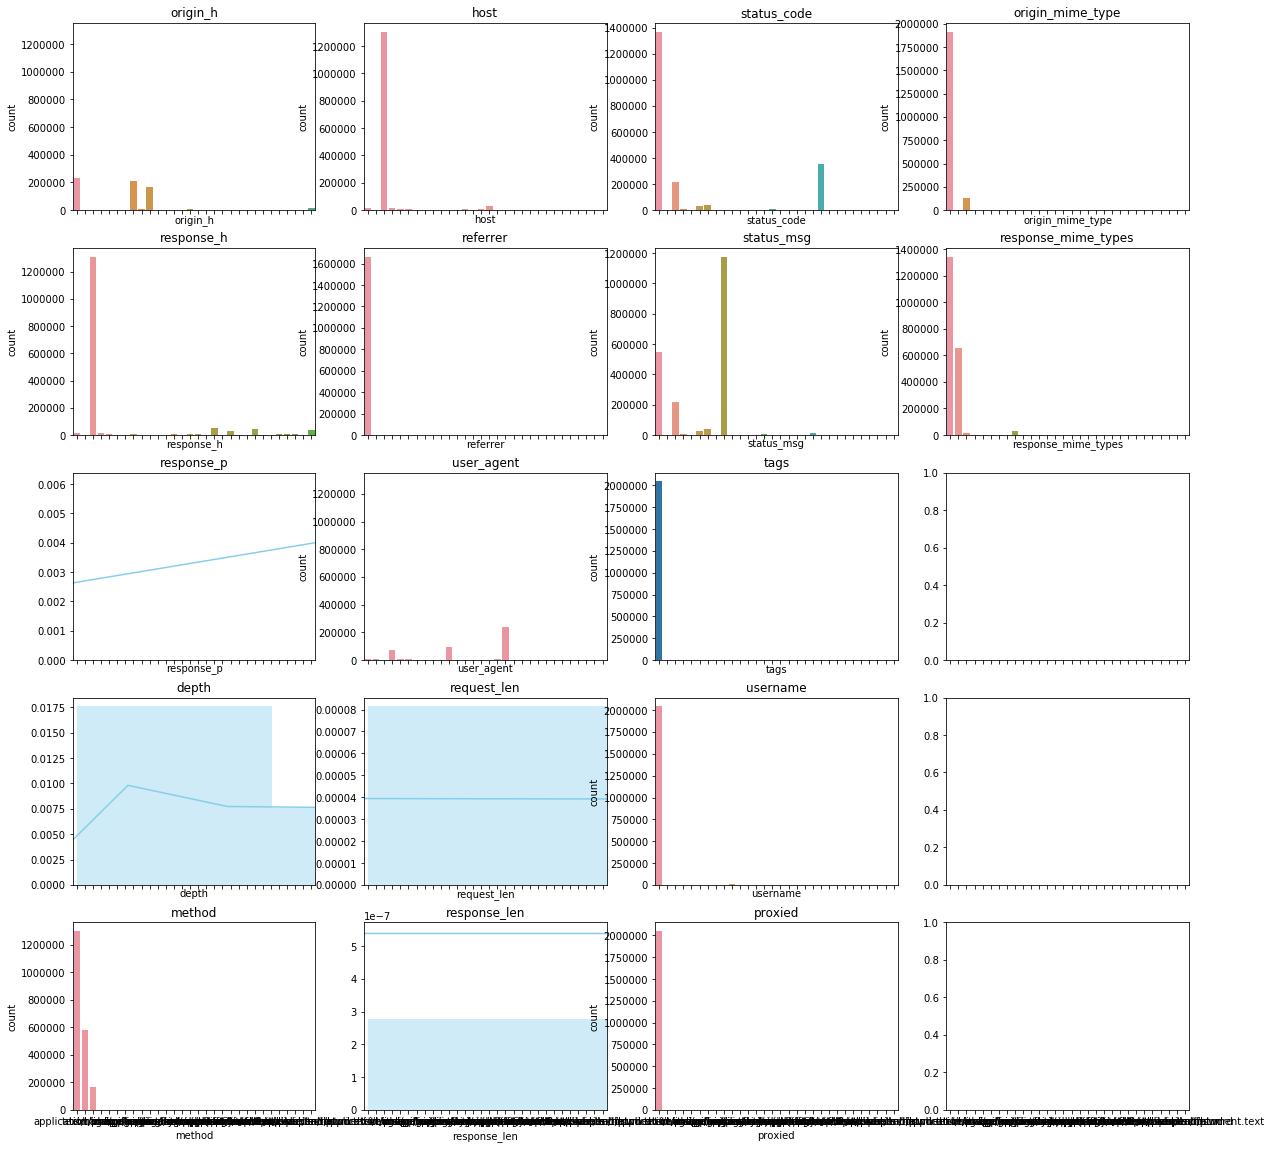

In [8]:
eda_cols = ['origin_h','response_h','response_p',\
                'depth','method','host','referrer','user_agent','request_len','response_len',\
                'status_code','status_msg','tags','username',\
                'proxied','origin_mime_type','response_mime_types']
f, axes = plt.subplots(5, 4, figsize=(20, 20), sharex=True)
for i, feature in enumerate(eda_cols):
    if np.issubdtype(df[feature].dtype, np.number): 
        _ = sns.distplot(df[feature] , color="skyblue", ax=axes[i%5, i//5]).set_title('{}'.format(feature))
    else:
        _ = sns.countplot(df[feature], ax=axes[i%5, i//5]).set_title('{}'.format(feature))

From the histogram and barplots of numeric and string value columns as well as the describe_df function, we see that most traffic is sent to a particular host and server IP address.  
We also see that most of the request results in 404 not found errors and interestingly, the most common user agent string "DirBuster" is matches a multi threaded java application designed to brute force directories and files, precisely for cyber recce purposes.  
This suggests that the data is quite heavily contaminated with malicious traffic.

# Interesting Findings
## Changing of user agents in a single connection. 

We see below that the user agent is a giveaway to a automated scanning toolkit, though I would venture only a portion of attackers would not change the user_agent string to something more normal.  
Also, the uri looks dodgy. 

In [11]:
df.groupby('uid')['user_agent'].nunique().nlargest(5)
df[df['uid']=='C0Qd5o4SfrPaJKJbCi'][['ts','uid','uri','user_agent', 'status_code']].head()

uid
C0Qd5o4SfrPaJKJbCi    101
C15GrT3SxmP7Su0kO3    101
C19xE123AebW0kwx      101
C2Qqdo32gyWysGLAdc    101
C3VbfQpB0JoqECMGb     101
Name: user_agent, dtype: int64

,ts,uid,uri,user_agent,status_code
1611151,2012-03-16 19:38:37.069999933,C0Qd5o4SfrPaJKJbCi,/sunshop.index.php?action=storenew&username=<script>alert('Vulnerable')</script>,Mozilla/5.00 (Nikto/2.1.5) (Evasions:None) (Test:000785),404
1611152,2012-03-16 19:38:37.069999933,C0Qd5o4SfrPaJKJbCi,/submit.php?subject=<script>alert('Vulnerable')</script>&story=<script>alert('Vulnerable')</script>&storyext=<script>alert('Vulnerable')</script>&op=Preview,Mozilla/5.00 (Nikto/2.1.5) (Evasions:None) (Test:000786),404
1611153,2012-03-16 19:38:37.069999933,C0Qd5o4SfrPaJKJbCi,/ss000007.pl?PRODREF=<script>alert('Vulnerable')</script>,Mozilla/5.00 (Nikto/2.1.5) (Evasions:None) (Test:000787),404
1611154,2012-03-16 19:38:37.069999933,C0Qd5o4SfrPaJKJbCi,/showcat.php?catid=&lt;Script&gt;JavaScript:alert('Vulnerable');&lt;/Script&gt;,Mozilla/5.00 (Nikto/2.1.5) (Evasions:None) (Test:000788),404
1611155,2012-03-16 19:38:37.069999933,C0Qd5o4SfrPaJKJbCi,"/shop/normal_html.cgi?file=&lt;script&gt;alert(\""Vulnerable\"")&lt;/script&gt;",Mozilla/5.00 (Nikto/2.1.5) (Evasions:None) (Test:000789),404


## Interesting HTTP Methods

GNUTELLA seems to indicate presence of a filesharing program.

In [12]:
df['method'].value_counts().nlargest(20)

HEAD           1296265
GET             580598
POST            165307
OPTIONS           2857
-                  876
PUT                500
CONNECT            255
DELETE             223
SEARCH             217
GNUTELLA           168
PROPFIND           158
TRACE              114
Secure              84
some                84
NESSUS              81
TRACK               69
RPC_CONNECT         40
DEBUG               20
INDEX               16
ACL                 12
Name: method, dtype: int64

## Interesting SQL-like commands in the uri field (SQL injection?)

In [13]:
df[df['uri'].str.contains('UNION')][['uri','user_agent']].head()

,uri,user_agent
554,"/?p4yl04d2=1 UNION ALL SELECT 1,2,3,table_name FROM information_schema.tables",Mozilla/5.0 (compatible; Nmap Scripting Engine; http://nmap.org/book/nse.html)
642,"/?p4yl04d2=1 UNION ALL SELECT 1,2,3,table_name FROM information_schema.tables",Mozilla/5.0 (compatible; Nmap Scripting Engine; http://nmap.org/book/nse.html)
877,"/?p4yl04d2=1 UNION ALL SELECT 1,2,3,table_name FROM information_schema.tables",Mozilla/5.0 (compatible; Nmap Scripting Engine; http://nmap.org/book/nse.html)
991,"/?p4yl04d2=1 UNION ALL SELECT 1,2,3,table_name FROM information_schema.tables",Mozilla/5.0 (compatible; Nmap Scripting Engine; http://nmap.org/book/nse.html)
1112,"/?p4yl04d2=1 UNION ALL SELECT 1,2,3,table_name FROM information_schema.tables",Mozilla/5.0 (compatible; Nmap Scripting Engine; http://nmap.org/book/nse.html)


This seems to be an attempt to scrape information about the underlying database

# Approach Adopted

From theory, reconnaissance activities refer to the objective of finding out information about any vulnerability that the server has, ports that it is listening to, user names, passwords of hosts, directory structures  etc.  
Possible ways to do so include port scanning, spamming logins and requesting for accesses to "common" resources that the attacker thinks the server would have.

__Machine Learning:__  
Due to the knowledge that this dataset has malicious users mixed with normal users, I do not think it would be feasible to do both supervised nor semi supervised learning.   
To do unsupervised learning, ie clustering, would require knowledge of what constitutes an example of malicious users so that I can see which clusters are highlighting the malicious users.  
In this implementation, I will be shortlisting based on "rules" based on my understanding of http traffic and my personal experience and ranking the IP addresses instead.
I will assign a score to each IP address without actually stipulating a threshold, this is because this dataset is known to contain malicious users and there is no "normal" traffic to compare with.  

In my opinion and based on what i know from previous work, some fields are more useful:  
1. username - repeated failed logins?  
2. status code - high numbers of 400s could be due to blind accessing of files by malicious users. I think 400s codes are a useful indicator.
3. response_ports - in port scanning operations, the attacker tries to access alot of ports to see if there are any open ports
4. user_agent - if there is a lot of user agent from 1 IP address, more likely to be suspicious? (this is a weaker indicator due to the fact that some IPs are gateways for bigger groups of users. Comparing the user agent against normally used agents could also reveal useful information, however, in this case, the dataset is in 2012, and all the user agents would look very outdated now. Manual inspection of the user agents reveals some potentially incriminating evidence of automated scripting behavior, however, user agent strings have very high categorical dimensions (many possible values) and it is challenging to set up a filter to catch specific keywords. It would be easier to setup a whitelist of typical user agent identities than to setup a blacklist, but in the absence of normal, day to day data, this cannot be done for this dataset.

Fields that I cannot see a use for, given my limited understanding of http traffic:
1. UID counts - high connection counts can be normal, however, a single connection with changing user agent during the connection is suspicious, my understanding is that user agent should not be changing in a single transaction (connection)  
2. request counts - high counts of requests is not a indicator by itself.
3. request/response_len: not sure how they relate to probing 
4. origin_p: from research, applications is free to open as many ports required and is usually random in a given range
5. depth: Connections that spans hundreds of requests have high depth, but i noticed that it is possible to have high depth with also alot of 400s errors. I normally expect that 400s would lead to a new connection attempt instead of continuing to send requests using the same connection.
6. method: I noticed some fringe methods like GNUTELLA when i did df['method'].value_counts(), but im not sure non-enterprise fileshares falls under reconnaissance activities.  
7. info_code, info_msg: not sure what they meant by "Last seen 1xx info reply code by server". Also there were only 2 non-empty rows.
8. password : It has been replaced with "-" so the entire column is empty.  
9. referrer, proxied, tags : not sure how it is useful here
10. origin_fuid, origin_mime_type, response_fuid, response_mime_type:  not sure how it is useful here
11. uri : Inspection of the uri field reveals some uri contain some interesting SQL-like commands like UNION. However, I believe it could also be legitimate traffic as well.
12. status_msg: in general the values are consistent, although different servers have slightly different text for the same error code

Assumptions for this approach:  
1. The IP address is trying to recce the servers from scratch, thus the rate of 400s error received from server should be similar from different servers.
2. I am making use of several simple rules to highlight suspicious behavior and in the absence of deeper knowledge, assume that these rules are equally important in identifying probing attempts.  


# Creating the Rules

In [14]:
df = get_data()
df['status_code'] = df['status_code'].astype(int)
#create additional column true or false if status_code is a 400 code.
df.loc[df['status_code'].isin([400,401,403,404,405,406,411,413,414,417]),'client_forbidden'] = True
df[['client_forbidden']] = df[['client_forbidden']].fillna(value=False)
df['unauthorized_access'] = df['status_code'].apply(lambda x: True if x in [401, 403] else False)
df["day_hour"] = df["ts"].dt.day.astype(str) +'_' +df["ts"].dt.hour.astype(str)
df[['username']] = df[['username']].replace('-',np.nan)

D:\Anaconda\envs\techtest\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [15]:
#For each IP, find the number of hours they are active in
active_hours_df = df.groupby('origin_h')['day_hour'].nunique().to_frame(name='active_hours')

In [16]:
#For each IP, find the number of requests sent
requests_count_df= df.groupby('origin_h').size().to_frame('request_count')



In [17]:
#For each IP, find the max number of user agents in a single connection
agent_connection_df = df.groupby(['origin_h','uid'])['user_agent'].nunique().reset_index().groupby('origin_h')['user_agent'].max().to_frame(name='max_agent_connection')


In [18]:
#For each IP, find the percentage of logins failed when they attempt to use a username (failed = 400 response code)
unsuccessful_login_df = df[df['username'].notnull()].groupby('origin_h').agg({'ts':'count', 'client_forbidden':'sum'})
unsuccessful_login_df['percentage_unsuccessful'] = unsuccessful_login_df['client_forbidden']/unsuccessful_login_df['ts']



In [19]:
#For each IP, find the % of 400s encountered of total requests
forbidden_request_df = df.groupby('origin_h').agg({'client_forbidden':'sum', 'ts':'count'})
forbidden_request_df['client_forbidden_percentage'] = forbidden_request_df['client_forbidden'] / forbidden_request_df['ts']
forbidden_request_df.columns = ['total_client_forbidden','total_request_count','percentage_requests_forbidden']



In [20]:
#For each IP, find the number of ports and ip address accessed
df['response_hp'] = df['response_h'] + '_'+ df['response_p'].astype(str)
ports_df = df.groupby('origin_h')['response_hp'].nunique().to_frame(name='number of diff ports and addresses accessed')



In [21]:
#max number of usernames attempted per host per origin IP address 
user_logins_df = df.groupby(['origin_h','host'])['username'].nunique().reset_index().groupby('origin_h')['username'].max()

In [22]:
summary_df = active_hours_df.merge(requests_count_df, how='left', left_index=True, right_index=True)\
                .merge(agent_connection_df, how='left', left_index=True, right_index=True)\
                .merge(forbidden_request_df, how='left', left_index=True, right_index=True)\
                .merge(ports_df, how='left', left_index=True, right_index=True)\
                .merge(user_logins_df, how='left', left_index=True, right_index=True)\
                .merge(unsuccessful_login_df[['percentage_unsuccessful']],how='left', left_index=True, right_index=True)       

In [24]:
summary_df = summary_df.fillna(value=0)

summary_df.columns=['hours_active','total_request_count','max_agent_in_connection','total_400_requests','total_request_count2','percentage_requests_400','num_ports_accessed','user_name_attempted','percentage_login_fail']
summary_df = summary_df[['hours_active','total_request_count','max_agent_in_connection','percentage_requests_400','num_ports_accessed','user_name_attempted','percentage_login_fail']]
summary_df.head(10)

,hours_active,total_request_count,max_agent_in_connection,percentage_requests_400,num_ports_accessed,user_name_attempted,percentage_login_fail
origin_h,,,,,,,
192.168.202.100,8,318,1,0.251572,14,2,0.833333
192.168.202.101,6,53,1,0.320755,11,0,0.000000
192.168.202.102,11,212234,1,0.205759,56,4,1.000000
192.168.202.103,10,2785,1,0.019031,16,1,0.000000
192.168.202.107,2,32,1,0.000000,1,0,0.000000
192.168.202.108,5,1336,1,0.160928,70,2,1.000000
192.168.202.109,3,109,1,0.073394,2,1,1.000000
192.168.202.110,8,169126,2,0.763514,54,20,0.200733
192.168.202.112,17,5631,1,0.039780,51,3,0.857143


# Scoring
There are a total of 5 rules implemented here:
1. % of requests that are forbidden
2. number of different ports in different addresses accessed (higher = more likely to be scanning for ports)
3. number of different user names attempted per host
4. % unsuccessful usernames attempts (if request has username and it returns a 400 code)
5. max number of user agent in a single connection from IP

a. Since each column has different min max values, I will use MinMaxScaler from Scikit-learn to bring all the values down to a 0-1 range. where 1 refers to a more likely suspicious statistic.     
b. Then, I will pad the numbers with a very small number to ensure non-zero value to facilitate the next step.    
c. I will then multiply the 5 scores and normalise it by taking root to get a score between 0 and 1.  


In [31]:
cols_of_interest = ['max_agent_in_connection','percentage_requests_400','num_ports_accessed','user_name_attempted','percentage_login_fail']
value_array = summary_df[cols_of_interest]
mms = MinMaxScaler()
transformed_array = mms.fit_transform(value_array) 
transformed_array += 0.0001
score = transformed_array[:,0] * transformed_array[:,1] * transformed_array[:,2] * transformed_array[:,3] * transformed_array[:,4]
norm_score = np.power(score, 1/5)



In [32]:
summary_df['Score_Final'] = score
summary_df = summary_df.sort_values(by='Score_Final', ascending=False)
summary_df.head(30)

,hours_active,total_request_count,max_agent_in_connection,percentage_requests_400,num_ports_accessed,user_name_attempted,percentage_login_fail,Score_Final
origin_h,,,,,,,,
192.168.202.79,11,232259,101,0.979794,79,68,0.993355,9.262769e-01
192.168.202.138,8,47379,7,0.757213,26,5,0.482014,4.927424e-04
192.168.202.110,8,169126,2,0.763514,54,20,0.200733,2.945967e-04
192.168.202.140,6,28332,2,0.668608,57,4,0.497175,1.351702e-04
192.168.202.125,2,8794,21,0.384922,2,1,1.000000,1.402629e-05
192.168.202.102,11,212234,1,0.205759,56,4,1.000000,8.137951e-07
192.168.202.96,5,10487,1,0.852484,19,3,0.857143,7.097300e-07
192.168.202.108,5,1336,1,0.160928,70,2,1.000000,3.999698e-07
192.168.202.118,4,14032,1,0.840365,6,4,0.882353,2.669117e-07


I believe the score can definitely be tweaked further to give the scores a more meaningful indication but in general, the more suspicious IP addresses are ranked up on top. I am unable to apply threshold as stated earlier due to this dataset being heavily contaminated and i do not have a normal baseline to set a threshold.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
def generate_score_from_dataset():
    columns=['ts','uid','origin_h','origin_p','response_h','response_p',\
                'depth','method','host','uri','referrer','user_agent','request_len','response_len',\
                'status_code','status_msg','info_code','info_msg','filename','tags','username',\
                'password','proxied','origin_fuid','origin_mime_type','response_fuid','response_mime_types']
    usecols = ['ts','uid','origin_h','origin_p','response_h','response_p','depth','method','host','uri',\
                'user_agent','status_code','filename','username']
    df = pd.read_csv('data_files/http.log.gz', compression='gzip', header=None, sep='\t', quoting=3, names = columns, usecols=usecols)
    
    df['origin_p']=df['origin_p'].astype('int')
    df['response_p']=df['response_p'].astype('int')
    df['depth']=df['depth'].astype('int')    
    df['ts'] = pd.to_datetime(df['ts'], unit='s', origin='unix')
    df.loc[df['status_code'] == '-','status_code'] = -1
    df['status_code'] = df['status_code'].astype(int)
    df['status_code'] = df['status_code'].astype(int)    
    df.loc[df['status_code'].isin([400,401,403,404,405,406,411,413,414,417]),'client_forbidden'] = True
    df[['client_forbidden']] = df[['client_forbidden']].fillna(value=False)
    df['unauthorized_access'] = df['status_code'].apply(lambda x: True if x in [401, 403] else False)
    df["day_hour"] = df["ts"].dt.day.astype(str) +'_' +df["ts"].dt.hour.astype(str)
    df[['username']] = df[['username']].replace('-',np.nan)
    active_hours_df = df.groupby('origin_h')['day_hour'].nunique().to_frame(name='active_hours')
    requests_count_df= df.groupby('origin_h').size().to_frame('request_count')
    agent_connection_df = df.groupby(['origin_h','uid'])['user_agent'].nunique().reset_index().groupby('origin_h')['user_agent'].max().to_frame(name='max_agent_connection')
    unsuccessful_login_df = df[df['username'].notnull()].groupby('origin_h').agg({'ts':'count', 'client_forbidden':'sum'})
    unsuccessful_login_df['percentage_unsuccessful'] = unsuccessful_login_df['client_forbidden']/unsuccessful_login_df['ts']
    forbidden_request_df = df.groupby('origin_h').agg({'client_forbidden':'sum', 'ts':'count'})
    forbidden_request_df['client_forbidden_percentage'] = forbidden_request_df['client_forbidden'] / forbidden_request_df['ts']
    forbidden_request_df.columns = ['total_client_forbidden','total_request_count','percentage_requests_forbidden']
    df['response_hp'] = df['response_h'] + '_'+ df['response_p'].astype(str)
    ports_df = df.groupby('origin_h')['response_hp'].nunique().to_frame(name='number of diff ports and addresses accessed')
    user_logins_df = df.groupby(['origin_h','host'])['username'].nunique().reset_index().groupby('origin_h')['username'].max()
    summary_df = active_hours_df.merge(requests_count_df, how='left', left_index=True, right_index=True)\
                    .merge(agent_connection_df, how='left', left_index=True, right_index=True)\
                    .merge(forbidden_request_df, how='left', left_index=True, right_index=True)\
                    .merge(ports_df, how='left', left_index=True, right_index=True)\
                    .merge(user_logins_df, how='left', left_index=True, right_index=True)\
                    .merge(unsuccessful_login_df[['percentage_unsuccessful']],how='left', left_index=True, right_index=True)       
    summary_df = summary_df.fillna(value=0)

    summary_df.columns=['hours_active','total_request_count','max_agent_in_connection','total_400_requests','total_request_count2','percentage_requests_400','num_ports_accessed','user_name_attempted','percentage_login_fail']
    summary_df = summary_df[['hours_active','total_request_count','max_agent_in_connection','percentage_requests_400','num_ports_accessed','user_name_attempted','percentage_login_fail']]
    cols_of_interest = ['max_agent_in_connection','percentage_requests_400','num_ports_accessed','user_name_attempted','percentage_login_fail']
    value_array = summary_df[cols_of_interest]
    mms = MinMaxScaler()
    transformed_array = mms.fit_transform(value_array) 
    transformed_array += 0.0001
    score = transformed_array[:,0] * transformed_array[:,1] * transformed_array[:,2] * transformed_array[:,3] * transformed_array[:,4]
    norm_score = np.power(score, 1/5)
    summary_df['Score_Final'] = score
    summary_df = summary_df.sort_values(by='Score_Final', ascending=False)
    summary_df.to_csv('scores_generated.csv')
    return 
